<a href="https://colab.research.google.com/github/sdinesh01/NLP-assignments/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression


## Section 0: Load the data

The data is available on Kaggle. Download. [here](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).

In [ ]:
## load the dataset
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# URL to the IMDB dataset
IMDB_REVIEWS = "https://raw.githubusercontent.com/JamesMTucker/DATA_340_NLP/master/Notebooks/data/IMDB_Dataset.csv"

# create dataframe
df = pd.read_csv(IMDB_REVIEWS) # if you have RAM issues, you can use the nrows argument to read in fewer rows

### Data Set Description

In [ ]:
## df shape and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


<Axes: xlabel='sentiment'>

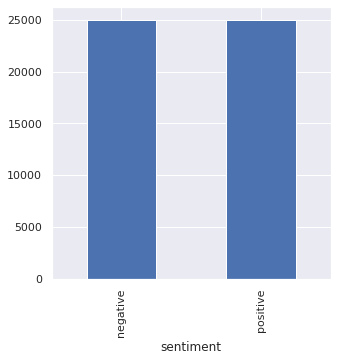

In [ ]:
# Analyze the distribution of the target variable

targets = df['sentiment'].groupby(df['sentiment']).count()

# plot the distribution of the target variable

df.groupby('sentiment').count()['review'].plot(kind='bar')

### Data set preview

In [ ]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


### Randomize some examples

In [ ]:
## randomly generate three examples from the dataset
from IPython.display import display, HTML

random_sample = df.sample(3)

## If negative, colorize the text red, otherwise colorize the text green
def colorize_text(text, sentiment):
    """Colorize pre-formatted text"""
    if sentiment == 'negative':
        return f'<span style="color:red">{text}</span>'
    if sentiment == 'positive':
        return f'<span style="color:green">{text}</span>'

for i in range(len(random_sample)):
    display(HTML(f"Review:<br />{colorize_text(random_sample.iloc[i]['review'], random_sample.iloc[i]['sentiment'])}"))

In [ ]:
random_sample

,review,sentiment
20356,This is bar none the most hilarious movie I ha...,positive
4768,"""Zen and the Art of Lanscaping"", written and d...",positive
39422,This movie was a fantastic comedy. It had a lo...,positive


## Section 1: Train a Logistic Regression model on noun and adjective phrases

Use the spaCy library to extract the noun and adjective phrases from the reviews and train a Logistic Regression model on the noun and adjective phrases.

`train` and `validation` are the data you should use to train and validate your model. `test` is the data you should use to test your model. `test` is the data that mimics real world data.

N.B.: Use the part of speech tags from spaCy to extract the noun and adjective phrases. For example, the noun phrase "the movie" is the head of the noun phrase "the movie was good". The adjective phrase "good" is the head of the adjective phrase "the movie was good".

In [ ]:
import nltk
nltk.download('stopwords')

import spacy
from nltk.corpus import stopwords
import string 

NLP = spacy.load("en_core_web_sm")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def extract_noun_adj_phrases(text):
    """Extract noun and adjective phrases from text.
    
    Args:
        text (str): Text to extract noun and adjective phrases from.
        
    Returns:
        noun_adj_phrases (list): List of noun and adjective phrases.
    """
    doc = NLP(text)
    noun_adj_phrases = []
    for token in doc:
        if token.pos_ in ["NOUN", "ADJ"]:
            noun_adj_phrases.append(token.text)
    return noun_adj_phrases

In [ ]:
# convert sentiment to integer labels 
labels = {'positive': 1, 'negative': 0}

df['sentiment'] = df['sentiment'].map(labels)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [ ]:
# extract noun and adjective phrases from reviews 
from tqdm import tqdm
tqdm.pandas()

df_a = df[:500].copy()
df_a['review'] = df_a['review'].progress_apply(extract_noun_adj_phrases)
df_a.head()

100%|██████████| 500/500 [00:47<00:00, 10.46it/s]


,review,sentiment
0,"[other, reviewers, Oz, episode, right, first, ...",1
1,"[wonderful, little, production, technique, una...",1
2,"[wonderful, way, time, hot, summer, weekend, a...",1
3,"[family, little, boy, zombie, closet, parents,...",0
4,"[Love, Money, stunning, film, vivid, portrait,...",1


In [ ]:
df_a.head()

,review,sentiment
0,"[other, reviewers, Oz, episode, right, first, ...",1
1,"[wonderful, little, production, technique, una...",1
2,"[wonderful, way, time, hot, summer, weekend, a...",1
3,"[family, little, boy, zombie, closet, parents,...",0
4,"[Love, Money, stunning, film, vivid, portrait,...",1


In [ ]:
# join words in "review" by space -- ONLY RUN THIS CELL ONCE

df_a['review'] = df_a['review'].apply(' '.join)

<Axes: xlabel='sentiment'>

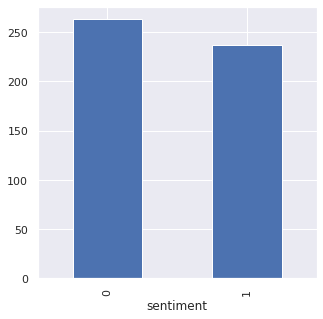

In [ ]:
## Check distribution of the labels from the random sample
df_a['token_count'] = df_a['review'].apply(lambda x: len(x.split()))
df_a.groupby('sentiment').count()['token_count'].plot(kind='bar')

In [ ]:
## convert our text to vectors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
# create instance of vectorizer
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df_a['review']).toarray()
y = df_a['sentiment'].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
## Check the shape of the data
len(X_train), len(X_val)

(400, 100)

In [ ]:
lr = LR(random_state = 310, solver='lbfgs', verbose=True)
lr.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


LogisticRegression(random_state=310, verbose=True)

In [ ]:
y_pred = lr.predict(X_val)

In [ ]:
## Evaluate the model's performance

accuracy_score(y_val, y_pred)

0.74

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

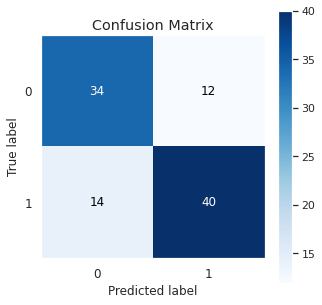

In [ ]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import seaborn as sns
sns.set(rc={'figure.figsize':(5,5)})
skplt.metrics.plot_confusion_matrix(y_val, y_pred)   

In [ ]:
print(classification_report(y_val, y_pred, target_names=['0 - negative', '1 - positive']))

              precision    recall  f1-score   support

0 - negative       0.71      0.74      0.72        46
1 - positive       0.77      0.74      0.75        54

    accuracy                           0.74       100
   macro avg       0.74      0.74      0.74       100
weighted avg       0.74      0.74      0.74       100



In [ ]:
# output some of the misclassified 
import numpy as np 
misclassified_0 = np.where(y_pred != y_val)[0]
print('Misclassified reviews:', len(misclassified_0))

misclassified_0 = misclassified_0.tolist()

Misclassified reviews: 26


In [ ]:
## create a dataframe to store the misclassified reviews
misclassified_df_0 = pd.DataFrame({'text': df_a['review'].iloc[misclassified_0], 
                                 'actual': df_a['sentiment'].iloc[misclassified_0], 
                                 'predicted': y_pred[misclassified_0]})
misclassified_df_0.head(10)

,text,actual,predicted
4,Love Money stunning film vivid portrait human ...,1,1
8,positive comments film film Bad mistake films ...,0,1
12,big fan work many movie only rights Far game s...,0,0
14,fantastic movie prisoners famous actors fan ro...,1,0
26,exotic masterpiece dizzying trip vast mind ser...,1,1
28,movie frustrating energetic prepared good time...,0,1
30,distinctive suspense thriller unlikely message...,1,0
42,films one Rage worst direction LOGIC continuit...,0,1
46,implausible movie grace good cast actors story...,0,0
47,film idea accurate nephew thousands years Cana...,0,1


## Section 2: Train a Logistic Regression model on verbs and adverbs

Use the spaCy library to extract the verbs and adjectives from the reviews and train a Logistic Regression model on the noun and adjective phrases.

`train` and `validation` are the data you should use to train and validate your model. `test` is the data you should use to test your model. `test` is the data that mimics real world data.

In [ ]:
def extract_verb_adv_phrases(text):
    """Extract verb and adverb phrases from text.
    Args:
        text (str): Text to extract noun and adjective phrases from.
    Returns:
        verb_adv_phrases (list): List of noun and adjective phrases.
    """
    doc = NLP(text)
    verb_adv_phrases = []
    for token in doc:
        if token.pos_ in ["VERB", "ADV"]:
            verb_adv_phrases.append(token.text)
    return verb_adv_phrases

In [ ]:
df_b = df[:500].copy()
df_b.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
df_b['review'] = df_b['review'].progress_apply(extract_verb_adv_phrases)
df_b.head()

100%|██████████| 500/500 [00:43<00:00, 11.45it/s]


,review,sentiment
0,"[mentioned, watching, just, hooked, exactly, h...",1
1,"[filming, very, very, gives, sometimes, discom...",1
2,"[thought, spend, too, sitting, conditioned, wa...",1
3,"[Basically, 's, thinks, 's, fighting, suddenly...",0
4,"[visually, watch, offers, seems, telling, do, ...",1


In [ ]:
# join words in "review" by space -- ONLY RUN THIS CELL ONCE

df_b['review'] = df_b['review'].apply(' '.join)
df_b.head()

,review,sentiment
0,mentioned watching just hooked exactly happene...,1
1,filming very very gives sometimes discomfortin...,1
2,thought spend too sitting conditioned watching...,1
3,Basically 's thinks 's fighting suddenly decid...,0
4,visually watch offers seems telling do encount...,1


In [ ]:
# create instance of vectorizer
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df_b['review']).toarray()
y = df_b['sentiment'].values

In [ ]:
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
lr = LR(random_state = 310, solver='lbfgs', verbose=True)
lr.fit(X_train_1, y_train_1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


LogisticRegression(random_state=310, verbose=True)

In [ ]:
y_pred_1 = lr.predict(X_val_1)

In [ ]:
## Evaluate the model's performance

accuracy_score(y_val_1, y_pred_1)

0.71

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

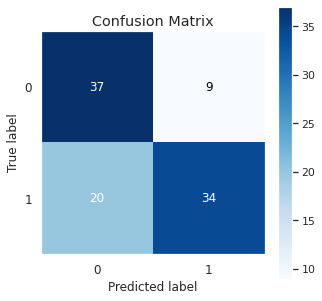

In [ ]:
# Create confusion matrix

sns.set(rc={'figure.figsize':(5,5)})
skplt.metrics.plot_confusion_matrix(y_val_1, y_pred_1)   

In [ ]:
print(classification_report(y_val_1, y_pred_1, target_names=['0 - negative', '1 - positive']))

              precision    recall  f1-score   support

0 - negative       0.65      0.80      0.72        46
1 - positive       0.79      0.63      0.70        54

    accuracy                           0.71       100
   macro avg       0.72      0.72      0.71       100
weighted avg       0.73      0.71      0.71       100



In [ ]:
# output some of the misclassified 
import numpy as np 
misclassified = np.where(y_pred_1 != y_val_1)[0]
print('Misclassified reviews:', len(misclassified))

misclassified = misclassified.tolist()

Misclassified reviews: 29


In [ ]:
## create a dataframe to store the misclassified reviews
misclassified_df = pd.DataFrame({'text': df_b['review'].iloc[misclassified], 
                                 'actual': df_b['sentiment'].iloc[misclassified], 
                                 'predicted': y_pred_1[misclassified]})
misclassified_df.head(10)

,text,actual,predicted
9,like wrenching like then love even liked,1,0
11,saw about came recall eating dangling helpless...,0,1
12,So m then again enjoyed maybe m apparently bou...,0,0
15,Kind of drawn only realize most ever seen Sort...,0,0
17,made most was was too running had wanted destr...,0,0
23,First let get straight here always used watch ...,0,0
24,saw also received afterwards only think receiv...,0,0
29,done redone so rehashed seem dealing Once howe...,1,0
35,bought sounded dragging was was Viewing though...,0,0
39,sitting wondered actually see produce that thr...,0,1


## Section 3: Compare the performance of the two models




The model trained on noun and adjective phrases performed better overall than the model trained on verb and adverbial phrases. 

| model      | accuracy score | # misclassified  | 
| :- |------------- | :-------------|
| nouns/adj      | 0.74     | 26 |
| verb/adv   | 0.71       | 29 |

Model 1 performed better with the classification of "positive" reviews, compared to Model 2. The F1 scores for positive reviews for both models are 0.75 and 0.70, respectively. However, their performances are flipped in terms of negative reviews, with precision scores 0.71 and 0.65, respectively. 

I believe the slight differences in accuracy may be attributed to the information conveyed by descriptive/adjectivial phrases. Adjectives convey the most information that could contribute to a positive/negative classification. Adverbs are descriptive, but less informative. A worthwhile follow-up to this analysis should study the effect of adjectivial phrases by rerunning the above models with only nouns and only verbs.

Another way to improve the performance of the model is to tune the hyperparameters for logistic regression. This would include testing different solvers, or optimization algorithms, and regularization methods (i.e. L1, L2, or elastic net). 

For this specific test, I limited the dataset size to 500 rows from the original 50,000, which could also affect the overall accuracy of both models. If runtime was not an issue, I would train and validate both models on larger amounts of data. This should improve accuracy as well. I would also compare the performance of data vectorized by tf-idf. 

Ultimately, logistic regression is limited by its inability to convey complex relationships between independent and dependent variables. It would be difficult, without repeated testing, to understand why one model outperformed the other by looking at their features alone. Logistic regression also assumes that there is no multicollinearlity and that the independent variable is correlated to the target variable.  

## Section 4: Extra Credit - Compare a Logistic regression model to a Naive Bayes model

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
df_c = df[:500].copy()
df_c['review'] = df_c['review'].progress_apply(extract_noun_adj_phrases)

100%|██████████| 500/500 [00:31<00:00, 15.94it/s]


In [ ]:
# join words in "review" by space -- ONLY RUN THIS CELL ONCE

df_c['review'] = df_c['review'].apply(' '.join)

In [ ]:
df_c

,review,sentiment
0,other reviewers Oz episode right first thing b...,1
1,wonderful little production technique unassumi...,1
2,wonderful way time hot summer weekend air thea...,1
3,family little boy zombie closet parents time.<...,0
4,Love Money stunning film vivid portrait human ...,1
...,...,...
495,opinion WORST MOVIE TIME.<br /><br friends ver...,0
496,book 9th grade class great movie beneficial mo...,0
497,movie boring few times name cover little kid t...,0
498,movie graphic sex scenes image movie much trut...,0


In [ ]:
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df_c['review']).toarray()
y = df_c['sentiment'].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(X_train),len(y_val)

(400, 100)

In [ ]:
nb = MultinomialNB()

# Fit the classifier on the training data
nb.fit(X_train, y_train)

MultinomialNB()

In [ ]:
y_pred = nb.predict(X_val)

In [ ]:
## Evaluate the model's performance
accuracy_score(y_val, y_pred)

0.74

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

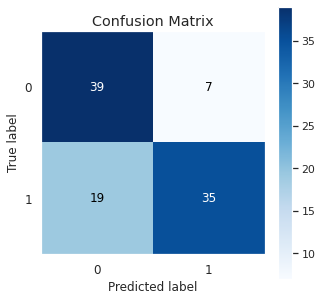

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
skplt.metrics.plot_confusion_matrix(y_val, y_pred)   

In [ ]:
print(classification_report(y_val_1, y_pred_1, target_names=['0 - negative', '1 - positive']))

              precision    recall  f1-score   support

0 - negative       0.65      0.80      0.72        46
1 - positive       0.79      0.63      0.70        54

    accuracy                           0.71       100
   macro avg       0.72      0.72      0.71       100
weighted avg       0.73      0.71      0.71       100



For this test, I ran a Multinomial Naive Bayes model on nouns and adjectives that was vectorized by the count vectorizer. This model is intended for comparison with the Logistic Regression model trained on nouns and adjectives. Both models were able to achieve an accuracy score of 74%. 

The logistic regression model classified both positive and negative reviews with similar precision scores. The Naive Bayes model performed markedly better with positive reviews compared to LR. NB was more likely to misclassify positive reviews as negative, and LR was more likely to misclassify negative reviews as positive